In [1]:
!pip3 install datasets

/bin/bash: /home/abhishek/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [159]:
from datasets import list_datasets, load_dataset
from pprint import pprint

# sst dataset

sst_valid = load_dataset('sst', split='test')
# convert to pandas dataframe
sst_valid_df = sst_valid.to_pandas()
# save to csv
sst_valid_df.to_csv('sst_test.csv', index=False)





No config specified, defaulting to: sst/default
Found cached dataset sst (/home/abhishek/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


In [160]:
# keep only the text and label column for sst dataset
# load the csv file in pandas dataframe
import pandas as pd 

sst_train_df = pd.read_csv('sst_train.csv')
sst_valid_df = pd.read_csv('sst_valid.csv')
sst_test_df = pd.read_csv('sst_test.csv')

sst_train_df = sst_train_df[['sentence','label']]
sst_valid_df = sst_valid_df[['sentence','label']]
sst_test_df = sst_test_df[['sentence','label']]
# save to csv
sst_train_df.to_csv('sst_train.csv', index=False)
sst_valid_df.to_csv('sst_valid.csv', index=False)
sst_test_df.to_csv('sst_test.csv', index=False)


In [175]:
def change_label(x):
    if x<=0.5:
        return 0
    else:
        return 1
        

In [176]:
# in sst_split change the labels according to threshold, divide them into 3 classes
# 0 - negative, 1 - neutral, 2 - positive
import pandas as pd

sst_train_df = pd.read_csv('sst_train.csv')
sst_valid_df = pd.read_csv('sst_valid.csv')
sst_test_df = pd.read_csv('sst_test.csv')

sst_train_df['label'] = sst_train_df['label'].apply(change_label)
sst_valid_df['label'] = sst_valid_df['label'].apply(change_label)
sst_test_df['label'] = sst_test_df['label'].apply(change_label)


sst_train_df.to_csv('sst_train_label.csv', index=False)
sst_valid_df.to_csv('sst_valid_label.csv', index=False)
sst_test_df.to_csv('sst_test_label.csv', index=False)

In [75]:
# multi_nli dataset
# keep premise and label 
multi_nli_train_df = pd.read_csv('multi_nli_test.csv')

multi_nli_train_df = multi_nli_train_df[['premise','label']]
multi_nli_train_df.to_csv('multi_nli_test.csv', index=False)

In [1]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

class PreProcessing():
    def __init__(self,filePath,savePath,minFreq):
        self.filePath = filePath
        self.savePath = savePath
        self.minFreq = minFreq
        self.word2idx = {}
        self.idx2word = {}
        self.word2count = {}
        self.vocab = []
        self.vocabSize = 0
        self.word2idx['<PAD>'] = 0
        self.word2idx['<UNK>'] = 1
        self.idx2word[0] = '<PAD>'
        self.idx2word[1] = '<UNK>'
        self.vocabSize = 2
        self.word2count['<PAD>'] = 0
        self.word2count['<UNK>'] = 0
        self.vocab.append('<PAD>')
        self.vocab.append('<UNK>')
        self.tokens = []
        self.label = []
        self.preProc = []
        self.preProc = self.removeWords()


    def removeWords(self):

        stop_words = set(stopwords.words('english'))
        punctuations = set(string.punctuation)
        ps = PorterStemmer()
        data = pd.read_csv(self.filePath)

        preProcessedData = []
        for sentence in tqdm(data['sentence'],desc='Preprocessing'):
            tokens = word_tokenize(sentence)
            filtered_tokens = [token.lower() for token in tokens if token not in stop_words and token not in punctuations]
            preProcessed_sentence = ' '.join(filtered_tokens)
            preProcessedData.append(preProcessed_sentence)


        word_counts = {}
        for sentence in preProcessedData:
            tokens = word_tokenize(sentence)
            for token in tokens:
                if token not in word_counts:
                    word_counts[token] = 1
                else:
                    word_counts[token] += 1

        for word,count in word_counts.items():
            if count >= self.minFreq:
                self.word2idx[word] = self.vocabSize
                self.word2count[word] = count
                self.idx2word[self.vocabSize] = word
                self.vocabSize += 1
                self.vocab.append(word)

        return preProcessedData



class GetDatasets(Dataset):
    def __init__(self,filePath,vocab,word2idx,pad):
        self.filePath = filePath
        self.vocab = vocab
        self.word2idx = word2idx
        self.tokens = []
        self.label = []
        self.pad = pad
        self.forward_data = []
        self.backward_data = []
        # self.tokenizeAndPad()
    
    # def tokenizeAndPad(self):
        data = pd.read_csv(self.filePath)
        maxLen = 0
        print(data.shape)
        for sentence in data['sentence']:
            tokens = word_tokenize(sentence)
            if len(tokens) > maxLen:
                maxLen = len(tokens)
        for i in tqdm(range(data.shape[0]),desc='Tokenising and Padding'):
            sentence = data['sentence'][i]
            tokens = word_tokenize(sentence)
            for j in range(len(tokens)):
                if tokens[j] in self.word2idx:
                    tokens[j] = self.word2idx[tokens[j]]
                else:
                    tokens[j] = self.word2idx['<UNK>']

            if self.pad:
                tokens.extend([self.word2idx['<PAD>']]*(maxLen-len(tokens)))

            data['sentence'][i] = tokens
            self.tokens.append(tokens)
            self.label.append(data['label'][i])
            self.forward_data.append(tokens[1:])
            self.backward_data.append(tokens[:-1])
            


        self.label = torch.tensor(self.label)
        self.tokens = torch.tensor(self.tokens)
        self.forward_data = torch.tensor(self.forward_data)
        self.backward_data = torch.tensor(self.backward_data)


    def __getitem__(self, index):
        return self.tokens[index], self.label[index],self.forward_data[index],self.backward_data[index]

    def __len__(self):
        return self.tokens.shape[0]


preProcessing = PreProcessing(
    './Data/sst_train_label.csv', './Data/sst_train_label.csv', 4)
train_data = GetDatasets('./Data/sst_train_label.csv',
                         preProcessing.vocab, preProcessing.word2idx, True)
valid_data = GetDatasets('./Data/sst_valid_label.csv',
                         preProcessing.vocab, preProcessing.word2idx, True)
test_data = GetDatasets('./Data/sst_test_label.csv',
                        preProcessing.vocab, preProcessing.word2idx, True)

# do for multi_nli dataset
# preProcessing = PreProcessing('multi_nli_train.csv','multi_nli_train.csv',4)
# train_data = GetDatasets('multi_nli_train.csv',preProcessing.vocab,preProcessing.word2idx,True)
# valid_data = GetDatasets('multi_nli_valid.csv',preProcessing.vocab,preProcessing.word2idx,True)
# test_data = GetDatasets('multi_nli_test.csv',   
#                         preProcessing.vocab, preProcessing.word2idx, True)

    


Preprocessing: 100%|██████████| 8544/8544 [00:01<00:00, 7700.99it/s]


(8544, 2)


Tokenising and Padding:   0%|          | 0/8544 [00:00<?, ?it/s]/tmp/ipykernel_163793/1438968735.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = tokens
Tokenising and Padding: 100%|██████████| 8544/8544 [00:03<00:00, 2147.95it/s]


(1101, 2)


Tokenising and Padding:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipykernel_163793/1438968735.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = tokens
Tokenising and Padding: 100%|██████████| 1101/1101 [00:00<00:00, 1802.72it/s]


(2210, 2)


Tokenising and Padding:   0%|          | 0/2210 [00:00<?, ?it/s]/tmp/ipykernel_163793/1438968735.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = tokens
Tokenising and Padding: 100%|██████████| 2210/2210 [00:00<00:00, 2222.50it/s]


In [3]:
VOCAB_SIZE = preProcessing.vocabSize
BATCH_SIZE = 32
EMBEDDING_DIM = 300
HIDDEN_DIM = 100
    

In [11]:
preProcessing.preProc[:10]

["the rock destined 21st century 's new `` conan `` 's going make splash even greater arnold schwarzenegger jean-claud van damme steven segal",
 "the gorgeously elaborate continuation `` the lord rings `` trilogy huge column words adequately describe co-writer\\/director peter jackson 's expanded vision j.r.r tolkien 's middle-earth",
 'singer\\/composer bryan adams contributes slew songs -- potential hits simply intrusive story -- whole package certainly captures intended er spirit piece',
 "you 'd think america would enough plucky british eccentrics hearts gold",
 'yet act still charming',
 "whether 're enlightened derrida 's lectures `` `` `` self `` derrida undeniably fascinating playful fellow",
 'just labour involved creating layered richness imagery chiaroscuro madness light astonishing',
 'part charm satin rouge avoids obvious humour lightness',
 'screenplay ingeniously constructed `` memento ``',
 '`` extreme ops `` exceeds expectations']

In [4]:
train_dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader = torch.utils.data.DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
tokens_test, label_test, forward_data_test, backward_data_test = next(iter(test_dataloader))

In [62]:
# load the glove embeddings
import numpy as np 
glove_file = './glove.6B/glove.6B.300d.txt'
glove_dict = {}
with open(glove_file, 'r',encoding = 'utf-8') as f:
    for line in f:
        tokens = line.strip().split(' ')
        word = tokens[0]
        embedding = np.array([float(val) for val in tokens[1:]])
        glove_dict[word] = embedding

# UNK and PAD embedding
UNK_emb = np.mean(list(glove_dict.values()), axis=0)
PAD_emb = np.zeros(300)


In [63]:
import torch
import torch.nn as nn
import tqdm

print(len(glove_dict))
cnt = 0

vocab = preProcessing.vocab
embeddings = []
for word in vocab:
    if word == '<UNK>':
        embeddings.append(UNK_emb)
    elif word == '<PAD>':
        embeddings.append(PAD_emb)
    elif word in glove_dict:
        cnt += 1
        embeddings.append(glove_dict[word])
    else:
        emb = np.random.uniform(-0.25,0.25,300)
        embeddings.append(emb)
    

print(cnt)


400000
37967


In [64]:
embeddings = torch.tensor(embeddings, dtype=torch.float)
# embeddings = torch.stack(embeddings)
embedding = nn.Embedding.from_pretrained(
    embeddings, freeze=False, padding_idx=0)

print(embedding.weight.shape)
# save the embedding
torch.save(embedding, 'embeddings2.pt')


torch.Size([41329, 300])


In [14]:
# laod from pickle 
import pickle 
embeddings = torch.load('./Data/embeddings1.pt')

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [16]:
class ELMo(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size, embedding_matrix):
        super(ELMo, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.embedding = embedding_matrix
        self.embedding.weight = nn.Parameter(
            self.embedding.weight, requires_grad=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim,
                             batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim*2, hidden_dim,
                             batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim*2, vocab_size)

    def forward(self, back_data):
        back_embed = self.embedding(back_data)
        back_lstm1, _ = self.lstm1(back_embed)
        back_lstm2, _ = self.lstm2(back_lstm1)
        linear_out = self.linear_out(back_lstm2)
        return linear_out


In [18]:
elmo = ELMo(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE, embeddings)
print(elmo)
elmo.to(device)

ELMo(
  (embedding): Embedding(4208, 300, padding_idx=0)
  (lstm1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=300, out_features=100, bias=True)
  (linear_out): Linear(in_features=200, out_features=4208, bias=True)
)


ELMo(
  (embedding): Embedding(4208, 300, padding_idx=0)
  (lstm1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=300, out_features=100, bias=True)
  (linear_out): Linear(in_features=200, out_features=4208, bias=True)
)

In [8]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch


In [15]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch

def train_epoch(model, train_dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    iter = 0
    for (tokens, label, forward, backward) in tqdm(train_dataloader, desc='Training'):
        forward = forward.to(device)
        backward = backward.to(device)
        optimizer.zero_grad()
        output = model(backward)
        loss = criterion(output.view(-1, VOCAB_SIZE), forward.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        iter += 1
        if iter%1000 == 0:
            print('Iteration: ', iter, 'Train Loss: ', total_loss/iter)
    return total_loss/len(train_dataloader)

def validate_epoch(model, valid_dataloader, criterion):
    model.eval()
    total_loss = 0
    iter = 0
    with torch.no_grad():
        for (tokens, label, forward, backward) in tqdm(valid_dataloader, desc='Validating'):
            forward = forward.to(device)
            backward = backward.to(device)
            output = model(backward)
            loss = criterion(output.view(-1, VOCAB_SIZE), forward.view(-1))
            total_loss += loss.item()
            iter += 1
            if iter%50 == 0:
                print('Iteration: ', iter, 'Validation Loss: ', total_loss/iter)
    return total_loss/len(valid_dataloader)

def train_model(model, train_dataloader, valid_dataloader, optimizer, criterion, epochs):
    best_valid_loss = float('inf')
    losses = {'epoch': [], 'train_loss': [], 'valid_loss': []}
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        train_loss = train_epoch(model, train_dataloader, optimizer, criterion)
        valid_loss = validate_epoch(model, valid_dataloader, criterion)
        print('Train Loss: ', train_loss, 'Valid Loss: ', valid_loss)
        losses['epoch'].append(epoch)
        losses['train_loss'].append(train_loss)
        losses['valid_loss'].append(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'elmo_model1.pt')
            print('Model saved')
    return losses

optimizer = optim.Adam(elmo.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
losses = train_model(elmo, train_dataloader, valid_dataloader, optimizer, criterion, 20)


Epoch:  0


Validating: 100%|██████████| 35/35 [00:00<00:00, 60.90it/s]


Train Loss:  4.624528033010075 Valid Loss:  3.6081675120762418
Model saved
Epoch:  1


Validating: 100%|██████████| 35/35 [00:00<00:00, 56.58it/s]


Train Loss:  3.150783465596174 Valid Loss:  2.5972355229513986
Model saved
Epoch:  2


Validating: 100%|██████████| 35/35 [00:00<00:00, 56.08it/s]


Train Loss:  2.3701883201741993 Valid Loss:  1.9996400220053536
Model saved
Epoch:  3


Validating: 100%|██████████| 35/35 [00:00<00:00, 53.83it/s]


Train Loss:  1.8569653547658456 Valid Loss:  1.5782367944717408
Model saved
Epoch:  4


Validating: 100%|██████████| 35/35 [00:00<00:00, 53.70it/s]


Train Loss:  1.481911128379879 Valid Loss:  1.2688020161220006
Model saved
Epoch:  5


Validating: 100%|██████████| 35/35 [00:00<00:00, 54.00it/s]


Train Loss:  1.1932680863566167 Valid Loss:  1.024587561403002
Model saved
Epoch:  6


Validating: 100%|██████████| 35/35 [00:00<00:00, 46.19it/s]


Train Loss:  0.9652503898527738 Valid Loss:  0.8347959637641906
Model saved
Epoch:  7


Validating: 100%|██████████| 35/35 [00:00<00:00, 45.71it/s]


Train Loss:  0.7820021085971304 Valid Loss:  0.678309576851981
Model saved
Epoch:  8


Validating: 100%|██████████| 35/35 [00:00<00:00, 44.75it/s]


Train Loss:  0.6327200067623724 Valid Loss:  0.5565443353993552
Model saved
Epoch:  9


Validating: 100%|██████████| 35/35 [00:00<00:00, 52.49it/s]


Train Loss:  0.5108233003803854 Valid Loss:  0.45500303677150183
Model saved
Epoch:  10


Validating: 100%|██████████| 35/35 [00:00<00:00, 52.54it/s]


Train Loss:  0.4103503999638647 Valid Loss:  0.37924752831459047
Model saved
Epoch:  11


Validating: 100%|██████████| 35/35 [00:00<00:00, 51.21it/s]


Train Loss:  0.32763542519526534 Valid Loss:  0.3066027275153569
Model saved
Epoch:  12


Validating: 100%|██████████| 35/35 [00:00<00:00, 51.41it/s]


Train Loss:  0.2588567115673412 Valid Loss:  0.2499971010855266
Model saved
Epoch:  13


Validating: 100%|██████████| 35/35 [00:00<00:00, 51.77it/s]


Train Loss:  0.20342567663514213 Valid Loss:  0.2044538357428142
Model saved
Epoch:  14


Validating: 100%|██████████| 35/35 [00:00<00:00, 49.47it/s]


Train Loss:  0.15868404133712755 Valid Loss:  0.16790808545691627
Model saved
Epoch:  15


Validating: 100%|██████████| 35/35 [00:00<00:00, 50.40it/s]


Train Loss:  0.1230746971282843 Valid Loss:  0.13772070365292685
Model saved
Epoch:  16


Validating: 100%|██████████| 35/35 [00:00<00:00, 41.10it/s]


Train Loss:  0.09487678772640809 Valid Loss:  0.11291930079460144
Model saved
Epoch:  17


Validating: 100%|██████████| 35/35 [00:00<00:00, 49.83it/s]


Train Loss:  0.07268985304353612 Valid Loss:  0.09406508643712316
Model saved
Epoch:  18


Validating: 100%|██████████| 35/35 [00:00<00:00, 49.08it/s]


Train Loss:  0.05584274712350038 Valid Loss:  0.0788170498396669
Model saved
Epoch:  19


Validating: 100%|██████████| 35/35 [00:00<00:00, 48.84it/s]


Train Loss:  0.043143640192093026 Valid Loss:  0.06745984011462756
Model saved


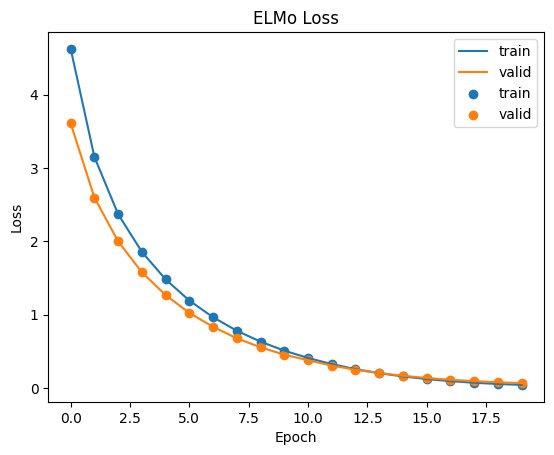

<Figure size 640x480 with 0 Axes>

In [16]:
from matplotlib import pyplot as plt
plt.plot(losses['epoch'], losses['train_loss'], label='train')
plt.plot(losses['epoch'], losses['valid_loss'], label='valid')
# mark with circle 
plt.scatter(losses['epoch'], losses['train_loss'], label='train')
plt.scatter(losses['epoch'], losses['valid_loss'], label='valid')
plt.title('ELMo Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('elmo1_loss.png')


In [19]:
elmo.load_state_dict(torch.load('./Data/elmo_model1.pt'))

<All keys matched successfully>

In [20]:
# Parameters
for name, param in elmo.named_parameters():
    if param.requires_grad:
        print(name, param.data, param.shape)
elmo_embeddings = list(elmo.parameters())[0].cpu().detach().numpy()
torch.save(elmo_embeddings, './Data/elmo_embeddings1.pt')


embedding.weight tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1528, -0.2565, -0.1229,  ...,  0.3585,  0.4474, -0.2414],
        [ 0.0763,  0.2342,  0.1978,  ..., -0.0429, -0.4216,  0.2478],
        ...,
        [ 0.7780,  0.2695,  0.0327,  ..., -0.4202,  0.2208, -0.3912],
        [ 0.2699, -0.2345, -0.0953,  ..., -0.5308,  0.0541,  0.0560],
        [ 0.0957,  0.4627,  0.0849,  ..., -0.3215, -0.1234, -0.2183]],
       device='cuda:0') torch.Size([4208, 300])
lstm1.weight_ih_l0 tensor([[ 0.0325,  0.0244,  0.0233,  ..., -0.0488,  0.0442, -0.1627],
        [ 0.0987, -0.1851,  0.0087,  ...,  0.0095,  0.0662, -0.0979],
        [ 0.0114, -0.0122, -0.1435,  ..., -0.2266, -0.0044, -0.0289],
        ...,
        [ 0.0501,  0.0896,  0.1861,  ...,  0.0297,  0.0052, -0.1195],
        [-0.0526,  0.1304,  0.0380,  ..., -0.0514, -0.1348,  0.4901],
        [-0.3702,  0.3825, -0.0636,  ..., -0.1133, -0.1338, -0.0523]],
       device='cuda:0') torch.Size([400, 300])
l

In [21]:
elmo_lstm1 = elmo.lstm1
print(elmo_lstm1.parameters())
elmo_lstm2 = elmo.lstm2
print(elmo_lstm2.parameters())
elmo_embeddings = list(elmo.parameters())[0].to(device)


<generator object Module.parameters at 0x7f64138e3d80>
<generator object Module.parameters at 0x7f64138e3d80>


In [22]:
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score
class scoreClassifier(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,elmoEmbedding,elmo_lstm1,elmo_lstm2,num_classes):
        super(scoreClassifier,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding.from_pretrained(elmoEmbedding, padding_idx=0)
        self.embeddings.weight = nn.Parameter(self.embeddings.weight,requires_grad=
                                              False)
        self.weights = nn.Parameter(torch.tensor([0.33,0.33,0.33]),requires_grad=False)
        self.lstm1 = elmo_lstm1
        self.lstm2 = elmo_lstm2
        self.linear1 = nn.Linear(embedding_dim, hidden_dim*2)
        self.linear_out = nn.Linear(hidden_dim*2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self,input_data):
        embed = self.embeddings(input_data)
        embedChange = self.linear1(embed)
        lstm1, _ = self.lstm1(embed)
        lstm2, _ = self.lstm2(lstm1)
        elmo_out = (self.weights[0]*lstm1 + self.weights[1]*lstm2 + self.weights[2]*embedChange)/(self.weights[0]+self.weights[1]+self.weights[2])
        elmo_max = torch.max(elmo_out, dim=1)[0]
        elmo_max = self.dropout(elmo_max)
        linear_out = self.linear_out(elmo_max)

        l2_reg = torch.tensor(0.).to(device)
        for param in self.linear1.parameters():
            l2_reg += torch.norm(param,2)
        for param in self.linear_out.parameters():
            l2_reg += torch.norm(param,2)

        # scores = self.relu(linear_out)
        return linear_out, l2_reg


In [23]:
classifier = scoreClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, elmo_embeddings, elmo_lstm1, elmo_lstm2, 2)
print(classifier)

scoreClassifier(
  (embeddings): Embedding(4208, 300, padding_idx=0)
  (lstm1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=300, out_features=200, bias=True)
  (linear_out): Linear(in_features=200, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [24]:
classifier.to(device)
#Initializing optimizer
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
#Initializing loss function
criterion = nn.CrossEntropyLoss()



In [143]:
def train_classifier_epoch(model, train_dataloader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    iter = 0
    total_acc = 0 
    for batch in tqdm(train_dataloader,desc="Training"):
        optimizer.zero_grad()
        batch = tuple(t.to(device) for t in batch)
        input_data,labels,_,_ = batch
        logits,l2_reg = model(input_data)
        loss = criterion(logits, labels) + 0.001*l2_reg
        loss.backward()
        optimizer.step()
        _,preds = torch.max(logits, dim=1)
        train_acc = accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
        total_acc += train_acc
        train_loss += loss.item()
        iter += 1
        if iter % 500 == 0:
            print("Iteration: {}, Train Loss: {}".format(iter, loss.item()))

    return train_loss/len(train_dataloader), total_acc/len(train_dataloader)

def eval_classifier_epoch(model, val_dataloader, criterion, device):
    model.eval()
    losses = 0
    iter = 0
    total_acc = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader,desc="Validation"):
            batch = tuple(t.to(device) for t in batch)
            input_data,labels,_,_ = batch
            logits,_ = model(input_data)
 
            _,preds = torch.max(logits, dim=1)
            val_acc = accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
            total_acc += val_acc
            loss = criterion(logits, labels) 
            losses += loss.item()
            iter += 1
            if iter % 50 == 0:
                print("Iteration: {}, Validation Loss: {}".format(iter, loss.item()))
    return losses/len(val_dataloader), total_acc/len(val_dataloader)

def train_classifier(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=10):

    losses = {'epoch': [], 'train_loss': [], 'valid_loss': []}
    acc = {'epoch': [], 'train_acc': [], 'valid_acc': []}
    min_valid_loss = float('inf')
    for epoch in range(epochs):
        print("Epoch: {}".format(epoch))

        train_loss,train_acc = train_classifier_epoch(model, train_dataloader, optimizer, criterion, device)
        val_loss,val_acc = eval_classifier_epoch(model, val_dataloader, criterion, device)
        if val_loss < min_valid_loss:
            min_valid_loss = val_loss
            print("Saving model...")
            torch.save(model.state_dict(), 'elmo1_classifier.pt')

        print("Train Loss: {}, Train Accuracy: {}".format(train_loss,train_acc))
        print("Validation Loss: {}, Validation Accuracy: {}".format(val_loss,val_acc))
        losses['epoch'].append(epoch)
        losses['train_loss'].append(train_loss)
        losses['valid_loss'].append(val_loss)
        acc['epoch'].append(epoch)
        acc['train_acc'].append(train_acc)
        acc['valid_acc'].append(val_acc)
        
    return losses,acc 

train_losses = train_classifier(classifier, train_dataloader, valid_dataloader, optimizer, criterion, device, epochs=30)


Epoch: 0


Validation: 100%|██████████| 35/35 [00:00<00:00, 82.26it/s]


Saving model...
Train Loss: 0.4236053290326944, Train Accuracy: 0.8471441947565543
Validation Loss: 0.692881417274475, Validation Accuracy: 0.5294642857142857
Epoch: 1


Validation: 100%|██████████| 35/35 [00:00<00:00, 79.94it/s]


Saving model...
Train Loss: 0.41477626020765485, Train Accuracy: 0.8355571161048689
Validation Loss: 0.6602250150271824, Validation Accuracy: 0.5857142857142857
Epoch: 2


Validation: 100%|██████████| 35/35 [00:00<00:00, 74.96it/s]


Saving model...
Train Loss: 0.40317995988585975, Train Accuracy: 0.8380149812734082
Validation Loss: 0.6496129393577575, Validation Accuracy: 0.605837912087912
Epoch: 3


Validation: 100%|██████████| 35/35 [00:00<00:00, 76.02it/s]


Saving model...
Train Loss: 0.3960798689711853, Train Accuracy: 0.8401217228464419
Validation Loss: 0.6453517292227063, Validation Accuracy: 0.6272664835164835
Epoch: 4


Validation: 100%|██████████| 35/35 [00:00<00:00, 72.68it/s]


Train Loss: 0.38873931771137293, Train Accuracy: 0.8428136704119851
Validation Loss: 0.6496232684169497, Validation Accuracy: 0.6406593406593407
Epoch: 5


Validation: 100%|██████████| 35/35 [00:00<00:00, 70.54it/s]


Saving model...
Train Loss: 0.3817614727698908, Train Accuracy: 0.846441947565543
Validation Loss: 0.6417400347334998, Validation Accuracy: 0.648695054945055
Epoch: 6


Validation: 100%|██████████| 35/35 [00:00<00:00, 65.02it/s]


Train Loss: 0.37871435862243846, Train Accuracy: 0.8474953183520599
Validation Loss: 0.6456474849155971, Validation Accuracy: 0.648695054945055
Epoch: 7


Validation: 100%|██████████| 35/35 [00:00<00:00, 54.96it/s]


Saving model...
Train Loss: 0.37130473155095783, Train Accuracy: 0.848314606741573
Validation Loss: 0.6377979274306979, Validation Accuracy: 0.6567307692307692
Epoch: 8


Validation: 100%|██████████| 35/35 [00:00<00:00, 64.88it/s]


Train Loss: 0.3629212367735552, Train Accuracy: 0.8521769662921348
Validation Loss: 0.640395969578198, Validation Accuracy: 0.6620879120879121
Epoch: 9


Validation: 100%|██████████| 35/35 [00:00<00:00, 65.91it/s]


Saving model...
Train Loss: 0.3525948722878199, Train Accuracy: 0.8590823970037453
Validation Loss: 0.6339541303259986, Validation Accuracy: 0.6656593406593406
Epoch: 10


Validation: 100%|██████████| 35/35 [00:00<00:00, 51.90it/s]


Saving model...
Train Loss: 0.3462445746256171, Train Accuracy: 0.8601357677902621
Validation Loss: 0.6256440149886268, Validation Accuracy: 0.6710164835164836
Epoch: 11


Validation: 100%|██████████| 35/35 [00:00<00:00, 54.17it/s]


Train Loss: 0.3345756292175711, Train Accuracy: 0.8648174157303371
Validation Loss: 0.6279137751885823, Validation Accuracy: 0.6719093406593407
Epoch: 12


Validation: 100%|██████████| 35/35 [00:00<00:00, 54.34it/s]


Saving model...
Train Loss: 0.3271067947260896, Train Accuracy: 0.8682116104868914
Validation Loss: 0.6001040667295456, Validation Accuracy: 0.699587912087912
Epoch: 13


Validation: 100%|██████████| 35/35 [00:00<00:00, 68.89it/s]


Train Loss: 0.3071735321303432, Train Accuracy: 0.8774578651685393
Validation Loss: 0.6089318360601153, Validation Accuracy: 0.6911401098901099
Epoch: 14


Validation: 100%|██████████| 35/35 [00:00<00:00, 65.46it/s]


Train Loss: 0.29565942454873845, Train Accuracy: 0.8867041198501873
Validation Loss: 0.6313138770205634, Validation Accuracy: 0.6942307692307692
Epoch: 15


Validation: 100%|██████████| 35/35 [00:00<00:00, 68.60it/s]


Train Loss: 0.2811543544133504, Train Accuracy: 0.8911516853932584
Validation Loss: 0.6198739332812173, Validation Accuracy: 0.6947115384615384
Epoch: 16


Validation: 100%|██████████| 35/35 [00:00<00:00, 55.05it/s]


Train Loss: 0.2593060633104839, Train Accuracy: 0.9029728464419475
Validation Loss: 0.6266540365559714, Validation Accuracy: 0.7054258241758242
Epoch: 17


Validation: 100%|██████████| 35/35 [00:00<00:00, 53.56it/s]


Train Loss: 0.24394670525070433, Train Accuracy: 0.9090589887640449
Validation Loss: 0.6202435042176928, Validation Accuracy: 0.7004807692307692
Epoch: 18


Validation: 100%|██████████| 35/35 [00:00<00:00, 66.74it/s]


Train Loss: 0.21815025712945935, Train Accuracy: 0.9222846441947565
Validation Loss: 0.6536318131855556, Validation Accuracy: 0.6978021978021978
Epoch: 19


Validation: 100%|██████████| 35/35 [00:00<00:00, 65.29it/s]


Train Loss: 0.20483693349339097, Train Accuracy: 0.9276685393258427
Validation Loss: 0.6619429503168378, Validation Accuracy: 0.7000686813186814
Epoch: 20


Validation: 100%|██████████| 35/35 [00:00<00:00, 65.90it/s]


Train Loss: 0.18358428873930976, Train Accuracy: 0.9373829588014981
Validation Loss: 0.6614005718912397, Validation Accuracy: 0.7036401098901099
Epoch: 21


Validation: 100%|██████████| 35/35 [00:00<00:00, 67.49it/s]


Train Loss: 0.16792937587207177, Train Accuracy: 0.9434691011235955
Validation Loss: 0.7262295143944877, Validation Accuracy: 0.685782967032967
Epoch: 22


Validation: 100%|██████████| 35/35 [00:00<00:00, 56.11it/s]


Train Loss: 0.14963096596495937, Train Accuracy: 0.9530664794007491
Validation Loss: 0.7963059672287532, Validation Accuracy: 0.6741758241758242
Epoch: 23


Validation: 100%|██████████| 35/35 [00:00<00:00, 53.00it/s]


Train Loss: 0.12984463986888362, Train Accuracy: 0.9625468164794008
Validation Loss: 0.8490419966833932, Validation Accuracy: 0.6625686813186813
Epoch: 24


Validation: 100%|██████████| 35/35 [00:00<00:00, 63.13it/s]


Train Loss: 0.11961060486147913, Train Accuracy: 0.9631320224719101
Validation Loss: 0.8501420795917511, Validation Accuracy: 0.6598901098901099
Epoch: 25


Validation: 100%|██████████| 35/35 [00:00<00:00, 59.93it/s]


Train Loss: 0.10429740863179, Train Accuracy: 0.9719101123595506
Validation Loss: 0.8957891251359668, Validation Accuracy: 0.660782967032967
Epoch: 26


Validation: 100%|██████████| 35/35 [00:00<00:00, 54.18it/s]


Train Loss: 0.09697703414418724, Train Accuracy: 0.9730805243445693
Validation Loss: 0.9490333233560835, Validation Accuracy: 0.6697115384615385
Epoch: 27


Validation: 100%|██████████| 35/35 [00:00<00:00, 51.91it/s]


Train Loss: 0.0878931229606215, Train Accuracy: 0.9775280898876404
Validation Loss: 1.073767045566014, Validation Accuracy: 0.6697115384615385
Epoch: 28


Validation: 100%|██████████| 35/35 [00:00<00:00, 64.47it/s]


Train Loss: 0.0767632783547546, Train Accuracy: 0.9824438202247191
Validation Loss: 1.1950545498303005, Validation Accuracy: 0.660782967032967
Epoch: 29


Validation: 100%|██████████| 35/35 [00:00<00:00, 63.78it/s]

Train Loss: 0.07333885927157902, Train Accuracy: 0.9831460674157303
Validation Loss: 1.3402965111391885, Validation Accuracy: 0.6500686813186813


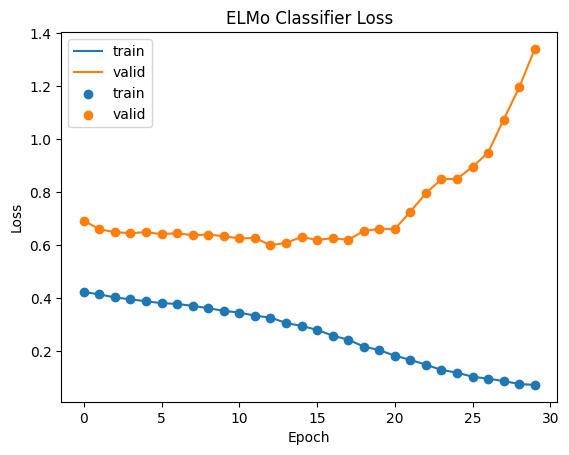

<Figure size 640x480 with 0 Axes>

In [144]:
# Plotting the loss
# train_losses = train_losses
losses,acc = train_losses
plt.plot(losses['epoch'], losses['train_loss'], label='train')
plt.plot(losses['epoch'], losses['valid_loss'], label='valid')
# mark with circle
plt.scatter(losses['epoch'], losses['train_loss'], label='train')
plt.scatter(losses['epoch'], losses['valid_loss'], label='valid')
plt.title('ELMo Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('elmo1_classifier_loss.png')

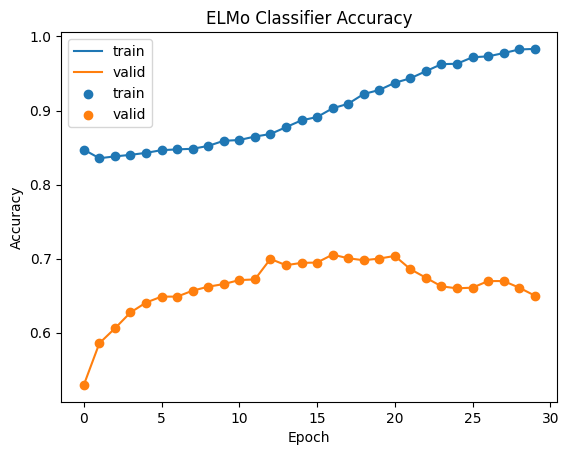

<Figure size 640x480 with 0 Axes>

In [145]:
# Plotting the accuracy
plt.plot(acc['epoch'], acc['train_acc'], label='train')
plt.plot(acc['epoch'], acc['valid_acc'], label='valid')
# mark with circle
plt.scatter(acc['epoch'], acc['train_acc'], label='train')
plt.scatter(acc['epoch'], acc['valid_acc'], label='valid')
plt.title('ELMo Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('elmo1_classifier_acc.png')

In [5]:
!pip3 install seaborn 

/bin/bash: /home/abhishek/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.4 MB/s eta 0:00:00a 0:00:01


Testing: 100%|██████████| 70/70 [00:00<00:00, 72.22it/s]


              precision    recall  f1-score   support

           0       0.66      0.91      0.77      1143
           1       0.84      0.50      0.63      1067

    accuracy                           0.71      2210
   macro avg       0.75      0.71      0.70      2210
weighted avg       0.75      0.71      0.70      2210

Accuracy: 0.7126696832579186
F1 Score: 0.6262507357268982
Precision: 0.8417721518987342
Recall: 0.4985941893158388
Confusion Matrix: 
[[1043.  100.]
 [ 535.  532.]]


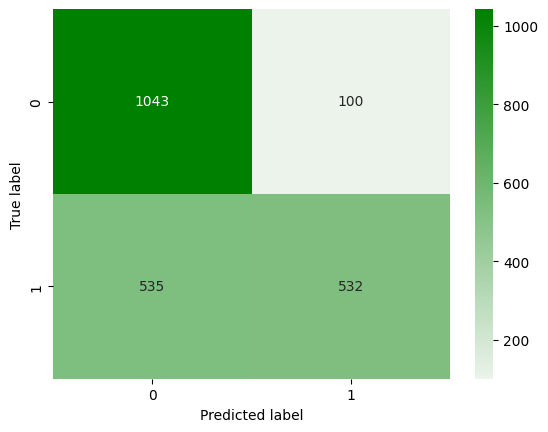

In [26]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

classifier.load_state_dict(torch.load('./Data/elmo1_classifier.pt'))
classifier.eval()
y_true = []
y_pred = []
confusion_matrix = np.zeros((2,2))

with torch.no_grad():
    for batch in tqdm(test_dataloader,desc="Testing"):
        batch = tuple(t.to(device) for t in batch)
        input_data,labels,_,_ = batch
        logits,_ = classifier(input_data)
        _,preds = torch.max(logits, dim=1)
        y_true.extend(labels.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())
        for i in range(len(labels)):
            confusion_matrix[labels[i]][preds[i]] += 1

print(classification_report(y_true, y_pred))
print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
print("F1 Score: {}".format(f1_score(y_true, y_pred)))
print("Precision: {}".format(precision_score(y_true, y_pred)))
print("Recall: {}".format(recall_score(y_true, y_pred)))
print("Confusion Matrix: ")
print(confusion_matrix)
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(confusion_matrix, cmap=cmap, annot=True, fmt="g")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


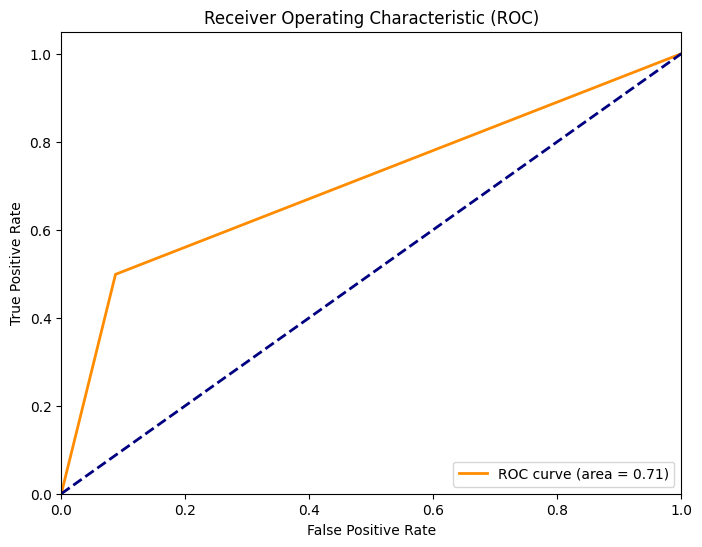

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assume y_true and y_scores are your true labels and predicted scores, respectively
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


Testing: 100%|██████████| 267/267 [00:03<00:00, 70.07it/s]


              precision    recall  f1-score   support

           0       0.67      0.95      0.79      4244
           1       0.92      0.54      0.68      4300

    accuracy                           0.75      8544
   macro avg       0.80      0.75      0.74      8544
weighted avg       0.80      0.75      0.74      8544

Accuracy: 0.7463717228464419
F1 Score: 0.6828625786623739
Precision: 0.9210422424003158
Recall: 0.5425581395348837
Confusion Matrix: 
[[4044.  200.]
 [1967. 2333.]]


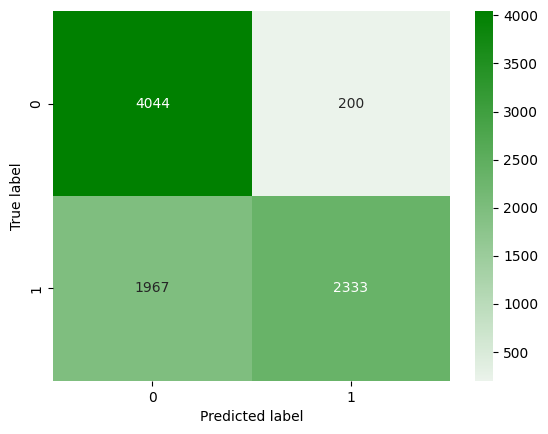

In [27]:
classifier.eval()
y_true = []
y_pred = []
confusion_matrix = np.zeros((2, 2))

with torch.no_grad():
    for batch in tqdm(train_dataloader, desc="Testing"):
        batch = tuple(t.to(device) for t in batch)
        input_data, labels, _, _ = batch
        logits, _ = classifier(input_data)
        _, preds = torch.max(logits, dim=1)
        y_true.extend(labels.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())
        for i in range(len(labels)):
            confusion_matrix[labels[i]][preds[i]] += 1

print(classification_report(y_true, y_pred))
print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
print("F1 Score: {}".format(f1_score(y_true, y_pred)))
print("Precision: {}".format(precision_score(y_true, y_pred)))
print("Recall: {}".format(recall_score(y_true, y_pred)))
print("Confusion Matrix: ")
print(confusion_matrix)
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(confusion_matrix, cmap=cmap, annot=True, fmt="g")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


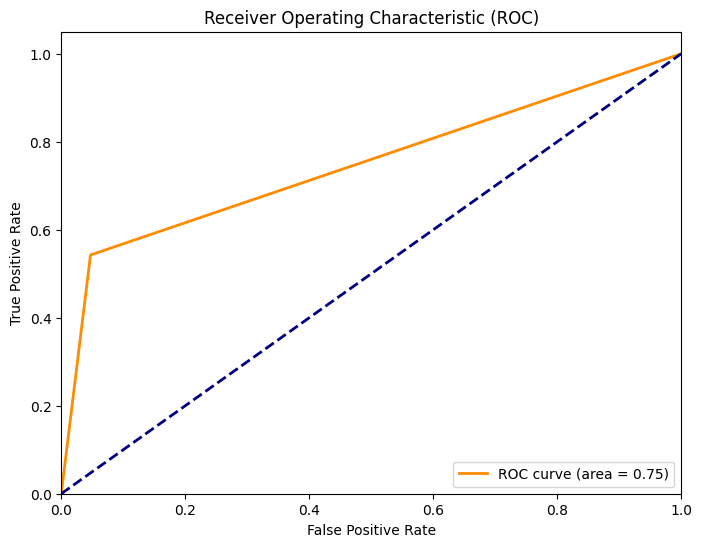

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assume y_true and y_scores are your true labels and predicted scores, respectively
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
